# Building a Spam Filter with Naive Bayes
***

In this project, we're going to build a SMS spam filter using the multinomial Naive Bayes algorithm. To do that, we're going to ***teach*** the computer how to classify messages along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The dataset can also be downloaded directly from [this link](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection). You can learn more of the data collection process on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition).

Note: due to the nature of spam messages, the dataset contains content that may be offensive to some readers.


## Objectives
Once our spam filter is done, we'll need to test how good it is with classifying new messages. To test the spam filter, we're first going to split our dataset into two categories:

- A training set, which we'll use to "train" the computer how to classify messages.
- A test set, which we'll use to test how good the spam filter is with classifying new messages.

## The Dataset
First, we start reading the dataset and desribing its properties.

In [1]:
import pandas as pd

sms_spam = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

print(f'The dataset has {sms_spam.shape[0]} rows and {sms_spam.shape[1]} columns.')
sms_spam.head(6)

The dataset has 5572 rows and 2 columns.


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...


Below, we see that 86.6% of the messages are ham, a message that is generally considered desired, while the remaining 13.4% are spam.

In [2]:
sms_spam['Label'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

ham     86.59%
spam    13.41%
Name: Label, dtype: object

### Training and Test Set
We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

- The training set will have 4,458 messages (about 80% of the dataset).
- The test set will have 1,114 messages (about 20% of the dataset).

In [3]:
# Randomizes the dataset before splitting
randomized_sms_spam = sms_spam.sample(frac=1, random_state=1)

# Splitting the randomized dataset
split_at = round(len(randomized_sms_spam) * 0.80)
training_set = randomized_sms_spam[:split_at].reset_index(drop=True)
test_set     = randomized_sms_spam[split_at:].reset_index(drop=True)

We'll now analyze the percentage of spam and ham messages in the training and test sets

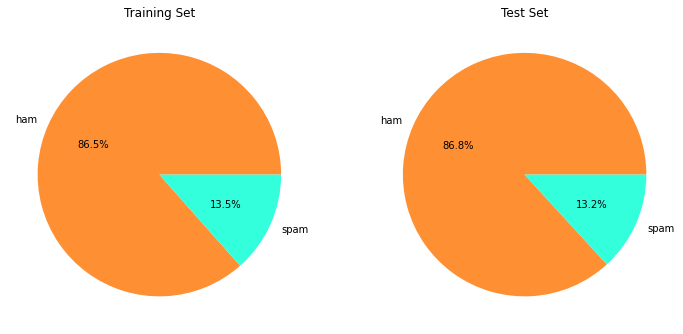

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Pie chart configs
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,10))
colors = ['#FF8F33','#33FFDC']

ax1.pie(training_set['Label'].value_counts(), labels=['ham', 'spam'], colors=colors, autopct='%1.1f%%')
ax1.title.set_text('Training Set')

ax2.pie(test_set['Label'].value_counts(), labels=['ham', 'spam'], colors=colors, autopct='%1.1f%%')
ax2.title.set_text('Test Set')

We see the percentages to be close to what we have in the full dataset, where about 87% of the messages are ham, and the remaining 13% are spam.

## Data Cleaning

To calculate all the probabilities required by the algorithm, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need.

Essentially, we want to bring data to this format:

![img](https://dq-content.s3.amazonaws.com/433/cpgp_dataset_3.png)

We start by removing all punctuation marks & lower casing all letters.

In [5]:
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ', regex=True).str.lower()
training_set.head(3)

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired


### Vocabulary
Let's now move to creating the vocabulary, which will contain all the unique words in our training set.

In [6]:
# Creating voucabulary for the messages in the training set
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)

vocabulary = list(set(vocabulary)) # removes duplicates
print("There are {:,} unique words in all of the messages of our training set".format(len(vocabulary)))

There are 7,783 unique words in all of the messages of our training set


### The Final Training Set

We're now going to use the vocabulary we just created to make the data transformation we want.

In [7]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [8]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,gn,videochat,5249,sux,gorgeous,customer,greeting,senor,newport,done,...,conform,hello,danger,lotsof,bulbs,caps,syllabus,reference,some1,castor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Merges training and word counts dataset
training_set = pd.concat([training_set, word_counts], axis = 1)
training_set.head()

,Label,SMS,gn,videochat,5249,sux,gorgeous,customer,greeting,senor,...,conform,hello,danger,lotsof,bulbs,caps,syllabus,reference,some1,castor
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Naive Bayes algorithm
Now that we're done with data cleaning and have a training set to work with, we can begin creating the spam filter. Using the Naive Bayes algorithm below, we'll be able to classify new messages.

\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
\end{equation}

\begin{equation}
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation}

Before we could calculate  P(w<sub>i</sub>|Spam) and P(w<sub>i</sub>|Ham) inside the formulas above, we need to calculate the parameters using these formulas:

\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
\end{equation}

\begin{equation}
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

### Calculating Constants

In [10]:
# Isolating spam and ham messages
spam_messages = training_set[training_set['Label'] == 'spam']
ham_messages = training_set[training_set['Label'] == 'ham']

# Prob(Spam) and Prob(Ham)
p_spam = len(spam_messages) / len(training_set)
p_ham = len(ham_messages) / len(training_set)

# No. of words in spam messages
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# No. of words in ham messages
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# No. of unique words in all messages
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

### Calculating Parameters

In [11]:
spam_parameters = {word:0 for word in vocabulary}
ham_parameters  = {word:0 for word in vocabulary}

for word in vocabulary:
    # Calculating parameters for spam msgs
    n_word_given_spam = spam_messages[word].sum()
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    spam_parameters[word] = p_word_given_spam

    # Calculating parameters for spam msgs
    n_word_given_ham = ham_messages[word].sum()
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    ham_parameters[word] = p_word_given_ham

## Spam Filter
Now that we've calculated all the constants and parameters we need, we can start creating the spam filter by creating a function that will classify a message if it's a spam or ham. The function will calculate the Naive Bayes probabilities. It will compare P(Spam|Message) with P(Ham|Message) and then prints a classification label. If the two probabilities are equal, we'll need a human classification.

In [12]:
import re

def classify(message):
    """
    Classifies if message is spam or not.
    """
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
    '''    
    This is where we calculate:

    p_spam_given_message = ?
    p_ham_given_message = ?
    '''    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in spam_parameters:
            p_spam_given_message *= spam_parameters[word]
            
        if word in ham_parameters:
            p_ham_given_message *= ham_parameters[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
        return 'spam'
    else:
        print('Equal proabilities, have a human classify this!')
        return 'needs human classification'

### Testing Spam Filter

In [13]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


'spam'

In [14]:
classify("Hello! Si Willie Revillame ito. Sabihin mo lang 'Salamat Shopee!'")

P(Spam|message): 4.440358548855192e-14
P(Ham|message): 4.659539300202712e-12
Label: Ham


'ham'

## Spam Filter's Accuracy
We'll now try to determine how well the spam filter does on our test set of 1,114 messages.The algorithm will output a classification label for every message in our test set, which we'll be able to compare with the actual label (given by a human). Note that, in training, our algorithm didn't see these 1,114 messages, so every message in the test set is practically new from the perspective of the algorithm. To make the measurement, we'll use accuracy as a metric:

\begin{equation}
Accuracy = \frac{\text{number of correctly classified messages}}{\text{total number of classified messages}}
\end{equation}

In [15]:
%%capture
test_set['predicted'] = test_set['SMS'].apply(classify)

In [16]:
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now, we'll calculate the accuracy of our spam filter.

In [17]:
correct = 0
total = test_set.shape[0]
    
for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', str(round(correct/total*100, 2)) + '%')

Correct: 1100
Incorrect: 14
Accuracy: 98.74%


Our model's accuracy in determining spam is about 98.74%, and has only 14 out of 1,114 messages tested that were classified incorrectly.

## Conclusions

Using the multinomial Naive Bayes algorithm, we have built a SMS spam filter  by teaching the model how to classify messages along with a dataset of 5,572 SMS messages that were already classified by humans. We've splitted and cleaned the original dataset into a training test and a test set, where the training set accounts for 80% of the data, and the test set for the remaining 20%. The spam filter had an accuracy of 98.74% on the dataset we've used, which is actually a very impressive result considering it only had 14 incorrect classification in the 1,114 test observations.